# Temporal Difference Control Methods - Part 3

In monte carlo control methods, we had to wait for the episode to finish in order to make Q table updates. In temporal difference (TD) methods, we update the table as soon as the agent starts interacting with the environment (i.e every timestep)

**Part 3**:  In this notebook, we will implement another on-policy method called Expected SARSA to estimate the optimal policy of CliffWalking gym environment.

# Import Libraries

In [1]:
import gym
import sys
import numpy as np
import pandas as pd
from collections import defaultdict, deque
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Gym Environment

Create gym environment and explore state and action space

In [2]:
# simple environment with discrete state and action space
env = gym.make('CliffWalking-v0')

In [3]:
# Explore state and action space
print('State space: {}'.format(env.observation_space))
print('Action space: {}'.format(env.action_space))

State space: Discrete(48)
Action space: Discrete(4)


Let us see how well does the random player performs

In [4]:
# Random player: takes random action
env.reset()
score = 0
while True:
    action = np.random.randint(env.action_space.n)
    state, reward, done, info = env.step(action)
    score += reward
    if done:
        print('last reward: {}, total score: {}'.format(reward, score))
        break

last reward: -1, total score: -73294


We continue using epsilon-greedy policy (same as monte carlo implementation)

In [5]:
def eps_greedy(eps, Q, state, nA):
    rand = np.random.rand()    
    if rand < eps:
        return np.random.randint(nA)
    else:
        return np.argmax(Q[state])

# EXPECTED SARSA


Update rule ->
$Q(S_t, A_t) = Q(S_t, A_t) + \alpha(R_t+1 + \gamma \, \sum_{a} \pi(a|S_{t+1}) Q(S_{t+1},a) - Q(S_t, A_t)$

In [11]:
def update_sarsa_Q(eps, nA, alpha, gamma, Q, state, action, next_state=None):    
    if next_state is not None:
        # default policy with equal probability
        policy = np.ones(nA) * eps/nA
        # Assign higher probability to the action with max Q value
        policy[np.argmax(Q[next_state])] = 1 - eps + eps/nA        
        Qsa = np.dot(Q[next_state], policy)
    else:
        Qsa = 0        
    updated_q_value = Q[state][action] + alpha * (reward + gamma * Qsa - Q[state][action])
    return updated_q_value

In [12]:
def generate_sarsa_episode(env, Q, eps, alpha, gamma):    
    nA = env.action_space.n
    state = env.reset()
    score = 0
    while True:
        action = eps_greedy(eps, Q, state, nA)
        next_state, reward, done, info = env.step(action)
        score += reward
        
        if not done:
            Q[state][action] = update_sarsa_Q(eps, nA, alpha, gamma, Q, state, action, next_state)
            state = next_state
            
        if done:
            Q[state][action] = update_sarsa_Q(eps, nA, alpha, gamma, Q, state, action)            
            break
            
    return Q, score

In [13]:
# Play for defined number of episodes
def train(env, num_episodes, eps=1.0, eps_min=0.01, eps_decay=0.9, alpha=0.01, gamma=1.0, plot_every=100):    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    print_every = int(0.1 * num_episodes)
    print_every = print_every if print_every > 0 else 1
    all_rewards = []
    tmp_rewards = deque(maxlen=plot_every)
    avg_rewards = deque(maxlen=num_episodes)
    for i in range(1, num_episodes + 1):
        eps = max(eps * eps_decay, eps_min)        
        Q, score = generate_sarsa_episode(env, Q, eps, alpha, gamma) 
        all_rewards.append(score)
        tmp_rewards.append(score)
        
        if i % print_every == 0:
            print('\rProgress: {}/{}, average: {}'.format(i, num_episodes, np.mean(score)), end='')
            sys.stdout.flush()        
            
        if i % plot_every == 0:
            avg_rewards.append(np.mean(tmp_rewards))
    return Q, all_rewards, avg_rewards

Train the agent and try to recover optimal policy (or near optimal)

In [56]:
# Hyperparameters (RL is very susceptible to hyperparams)

eps = 1.0       # starting epsilon
eps_min = 0.01  # minimum epsilon
eps_decay = 0.9 # decay rate
alpha = 0.01    # Q value update step size
gamma = 1.0     # discount factor

Q_sarsa_orig, score_orig, avg_score_orig = train(env, 5000, eps=eps, eps_min=eps_min, eps_decay=eps_decay, alpha=alpha, gamma=gamma)

Progress: 5000/5000, average: -13.0

Lets see the impact of alpha when we reduce the number of training episodes. Here we have reduced the number of training episodes from 5000 to 100

In [48]:
eps = 1.0       # starting epsilon
eps_min = 0.01  # minimum epsilon
eps_decay = 0.9 # decay rate
alpha = 0.01     # Q value update step size
gamma = 1.0     # discount factor

Q_sarsa, score, avg_score = train(env, 100, eps=eps, eps_min=eps_min, eps_decay=eps_decay, alpha=alpha, gamma=gamma)

Progress: 100/100, average: -497.0

It seems the agent is learning very slowly, increasing alpha from 0.01 to 0.3 does speed up the training

In [51]:
eps = 1.0       # starting epsilon
eps_min = 0.01  # minimum epsilon
eps_decay = 0.9 # decay rate
alpha = 0.3     # Q value update step size
gamma = 1.0     # discount factor

Q_sarsa, score, avg_score = train(env, 100, eps=eps, eps_min=eps_min, eps_decay=eps_decay, alpha=alpha, gamma=gamma)

Progress: 100/100, average: -13.0

# Visualise

In [57]:
policy = np.array([np.argmax(Q_sarsa_orig[key]) if key in Q_sarsa else -1 for key in np.arange(12*4)])

In [58]:
# UP: 0, RIGHT: 1, DOWN: 2, LEFT: 3, N/A: -1
# Display policy
policy.reshape(4, 12)

array([[ 2,  0,  1,  1,  1,  0,  1,  1,  3,  1,  2,  2],
       [ 2,  3,  1,  1,  1,  1,  2,  1,  1,  1,  1,  2],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2],
       [ 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

Plot average rewards over the total number of episodes

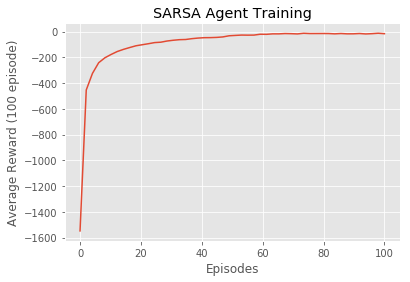

In [59]:
plt.plot(np.linspace(0, 100, len(avg_score_orig)), np.asarray(avg_score_orig))
plt.xlabel('Episodes')
plt.ylabel('Average Reward (100 episode)')
plt.title('SARSA Agent Training')
plt.show()

# Try it out

In [23]:
# Use policy to play
state = env.reset()
score = 0
while True:
    action = np.argmax(Q_sarsa[state])
    state, reward, done, info = env.step(action)
    score += reward
    if done:
        print('last reward: {}, total score: {}'.format(reward, score))
        break

last reward: -1, total score: -13
